In [2]:
!pip install --quiet albumentations==2.0.5
!pip install --quiet opencv-python-headless
!pip install --quiet seaborn
!pip install --quiet scikit-learn
!pip install --quiet pillow
!pip install --quiet tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 8.0 MB/s eta 0:00:00:00:01


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as Models
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score
from tqdm import tqdm

In [ ]:
RandomState = 2022484
np.random.seed(RandomState)
random.seed(RandomState)
torch.manual_seed(RandomState)
Device = torch.device("cuda")
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
class DenseNetRefixMatch(nn.Module):
    def __init__(self, NumClasses=100):
        super(DenseNetRefixMatch, self).__init__()
        Backbone = Models.densenet121(weights=Models.DenseNet121_Weights.DEFAULT)
        Backbone.features.conv0 = nn.Conv2d(
            in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False
        )
        nn.init.kaiming_normal_(Backbone.features.conv0.weight, mode='fan_out', nonlinearity='relu')
        self.Features = Backbone.features
        self.Classifier = nn.Linear(Backbone.classifier.in_features, NumClasses)
        
    def forward(self, X):
        FeaturesOut = self.Features(X)
        ReluOut = F.relu(FeaturesOut, inplace=True)
        PooledOut = F.adaptive_avg_pool2d(ReluOut, (1, 1))
        FlattenedOut = torch.flatten(PooledOut, 1)
        Logits = self.Classifier(FlattenedOut)
        return Logits

In [ ]:
def LoadCifar100(DatasetPath):
    Data = []
    ClassToIdx = {}
    IdxToClass = {}
    SuperclassToClass = {}
    IdxToSuperclass = {}

    for SuperclassIdx, (Superclass, ClassDirs) in enumerate(
            [(Folder, os.listdir(os.path.join(DatasetPath, Folder))) for Folder in os.listdir(DatasetPath)]
        ):
        SuperclassToClass[Superclass] = []
        IdxToSuperclass[SuperclassIdx] = Superclass
        for ClassName in ClassDirs:
            ClassPath = os.path.join(DatasetPath, Superclass, ClassName)
            if os.path.isdir(ClassPath):
                if ClassName not in ClassToIdx:
                    ClassToIdx[ClassName] = len(ClassToIdx)
                    IdxToClass[ClassToIdx[ClassName]] = ClassName
                SuperclassToClass[Superclass].append(ClassToIdx[ClassName])
                for ImgPath in glob(os.path.join(ClassPath, "*.png")):
                    ImageArray = np.array(Image.open(ImgPath).convert("RGB"))
                    Data.append((ImageArray, ClassToIdx[ClassName], SuperclassIdx))
    print(f"Dataset loaded with {len(Data)} images across {len(ClassToIdx)} classes and {len(SuperclassToClass)} superclasses.")
    return Data, ClassToIdx, IdxToClass, SuperclassToClass, IdxToSuperclass

In [ ]:
def PlotClassDistribution(Data, IdxToClass):
    ClassCounts = {}
    for (_, Label, _) in Data:
        ClassName = IdxToClass[Label]
        ClassCounts[ClassName] = ClassCounts.get(ClassName, 0) + 1
    SortedClasses = sorted(ClassCounts.keys())
    Counts = [ClassCounts[Cls] for Cls in SortedClasses]
    plt.figure(figsize=(20, 6))
    sns.barplot(x=SortedClasses, y=Counts)
    plt.title("CIFAR-100 Class Distribution", fontsize=16)
    plt.xlabel("Class Name", fontsize=14)
    plt.ylabel("Image Count", fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [ ]:
def PlotSuperclassDistribution(Data, IdxToSuperclass):
    SuperclassCounts = {}
    for (_, _, Superclass) in Data:
        SuperclassName = IdxToSuperclass[Superclass]
        SuperclassCounts[SuperclassName] = SuperclassCounts.get(SuperclassName, 0) + 1
    SortedSuperclasses = sorted(SuperclassCounts.keys())
    Counts = [SuperclassCounts[Scls] for Scls in SortedSuperclasses]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=SortedSuperclasses, y=Counts)
    plt.title("CIFAR-100 Superclass Distribution", fontsize=16)
    plt.xlabel("Superclass Name", fontsize=14)
    plt.ylabel("Image Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
def DisplayRandomImages(Data, IdxToClass, IdxToSuperclass, NumImages=20):
    RandomIndices = random.sample(range(len(Data)), NumImages)
    SelectedData = [Data[i] for i in RandomIndices]
    fig, Axes = plt.subplots(4, 5, figsize=(12, 10))
    for Ax, (ImageArray, Label, Superclass) in zip(Axes.flat, SelectedData):
        Ax.imshow(ImageArray)
        Ax.axis("off")
        Ax.set_title(f"{IdxToClass[Label]}\n({IdxToSuperclass[Superclass]})", fontsize=8)
    plt.suptitle("Random Sample Images from CIFAR-100", fontsize=18)
    plt.tight_layout()
    plt.show()

In [ ]:
def DisplayAugmentedImages(Data, NumImages=10):
    WeakTransform = A.Compose([
        A.RandomCrop(32, 32, p=1.0),
        A.HorizontalFlip(p=1.0)
    ])
    StrongTransform = A.Compose([
        A.Perspective(scale=(0.05, 0.1), p=1.0),
        A.Affine(shear=15, p=1.0),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.RandomBrightnessContrast(p=1.0),
            A.RandomGamma(p=1.0)
        ], p=1.0)
    ])
    RandomSamples = random.sample(Data, NumImages)
    fig, Axes = plt.subplots(3, NumImages, figsize=(15, 10))
    for I, (ImageArray, _, _) in enumerate(RandomSamples):
        Original = ImageArray
        WeakAug = WeakTransform(image=Original)['image']
        StrongAug = StrongTransform(image=Original)['image']
        Axes[0, I].imshow(Original)
        Axes[0, I].axis("off")
        Axes[0, I].set_title("Original", fontsize=8)
        Axes[1, I].imshow(WeakAug)
        Axes[1, I].axis("off")
        Axes[1, I].set_title("Weak Augmentation", fontsize=8)
        Axes[2, I].imshow(StrongAug)
        Axes[2, I].axis("off")
        Axes[2, I].set_title("Strong Augmentation", fontsize=8)
    plt.suptitle("Demonstration of Image Augmentations", fontsize=18)
    plt.tight_layout()
    plt.show()

In [ ]:
def FixedCountSplit(Data, NumPerClass):
    ClassDict = {}
    for Item in Data:
        ImageArray, Label, Superclass = Item
        if Label not in ClassDict:
            ClassDict[Label] = []
        ClassDict[Label].append(Item)
    Labeled = []
    Unlabeled = []
    for Label, Items in ClassDict.items():
        random.shuffle(Items)
        if len(Items) > NumPerClass:
            Labeled.extend(Items[:NumPerClass])
            Unlabeled.extend(Items[NumPerClass:])
        else:
            Labeled.extend(Items)
    return Labeled, Unlabeled

In [ ]:
def SplitDataFixedCountAlt(Data, NumPerClass):
    TrainData, TempData = train_test_split(
        Data, train_size=0.8, stratify=[X[1] for X in Data], random_state=RandomState
    )
    ValData, TestData = train_test_split(
        TempData, train_size=0.5, stratify=[X[1] for X in TempData], random_state=RandomState
    )
    LabeledData, UnlabeledData = FixedCountSplit(TrainData, NumPerClass)
    print(f"\n[Data Split] Fixed Count: {NumPerClass} labeled samples per class")
    print(f"Labeled Training Data: {len(LabeledData)} samples")
    print(f"Unlabeled Training Data: {len(UnlabeledData)} samples")
    print(f"Validation Data: {len(ValData)} samples")
    print(f"Test Data: {len(TestData)} samples")
    return LabeledData, UnlabeledData, ValData, TestData

In [ ]:
class Cifar100ReFixMatchDataset(Dataset):
    def __init__(self, Data, TransformOriginal, TransformWeak, TransformStrong):
        self.Data = Data
        self.TransformOriginal = TransformOriginal
        self.TransformWeak = TransformWeak
        self.TransformStrong = TransformStrong

    def __getitem__(self, Index):
        ImageArray, Label, _ = self.Data[Index]
        Original = self.TransformOriginal(image=ImageArray)['image']
        Weak = self.TransformWeak(image=ImageArray)['image']
        Strong = self.TransformStrong(image=ImageArray)['image']
        return {'Original': Original, 'Weak': Weak, 'Strong': Strong, 'Label': Label}

    def __len__(self):
        return len(self.Data)

In [ ]:
class Cifar100TestDataset(Dataset):
    def __init__(self, Data, Transform):
        self.Data = Data
        self.Transform = Transform

    def __getitem__(self, Index):
        ImageArray, Label, _ = self.Data[Index]
        Transformed = self.Transform(image=ImageArray)['image']
        return Transformed, Label

    def __len__(self):
        return len(self.Data)

In [ ]:
def main():
    Mean = (0.5, 0.5, 0.5)
    Std = (0.5, 0.5, 0.5)
    TransformOriginal = A.Compose([
        A.Resize(32, 32),
        A.Normalize(mean=Mean, std=Std, max_pixel_value=255.0),
        ToTensorV2()
    ])
    TransformWeak = A.Compose([
        A.Resize(32, 32),
        A.RandomCrop(32, 32, p=1.0),
        A.HorizontalFlip(p=1.0),
        A.Normalize(mean=Mean, std=Std, max_pixel_value=255.0),
        ToTensorV2()
    ])
    TransformStrong = A.Compose([
        A.Resize(32, 32),
        A.Perspective(scale=(0.05, 0.1), p=1.0),
        A.Affine(shear=15, p=1.0),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=1.0),
            A.RandomBrightnessContrast(p=1.0),
            A.RandomGamma(p=1.0)
        ], p=1.0),
        A.Normalize(mean=Mean, std=Std, max_pixel_value=255.0),
        ToTensorV2()
    ])

    dataset_path = r"/kaggle/input/cifar-100/cifar_100"
    Data, ClassToIdx, IdxToClass, SuperclassToClass, IdxToSuperclass = LoadCifar100(dataset_path)

    PlotClassDistribution(Data, IdxToClass)
    PlotSuperclassDistribution(Data, IdxToSuperclass)
    DisplayRandomImages(Data, IdxToClass, IdxToSuperclass, NumImages=20)
    DisplayAugmentedImages(Data, NumImages=10)

    FixedCounts = [75, 175, 260, 360]
    Results = {}       
    AllMetrics = {} 
    Eps = 1e-8
    Tau = 0.95
    LambdaU = 0.8
    NumEpochs = 20

    for FixedCount in FixedCounts:
        print(f"\n=== Running experiment with {FixedCount} labeled samples per class ===")
        LabeledDataFixed, UnlabeledDataFixed, ValDataFixed, TestDataFixed = SplitDataFixedCountAlt(Data, FixedCount)

        LabeledDatasetFixed = Cifar100ReFixMatchDataset(
            Data=LabeledDataFixed, TransformOriginal=TransformOriginal,
            TransformWeak=TransformWeak, TransformStrong=TransformStrong
        )
        UnlabeledDatasetFixed = Cifar100ReFixMatchDataset(
            Data=UnlabeledDataFixed, TransformOriginal=TransformOriginal,
            TransformWeak=TransformWeak, TransformStrong=TransformStrong
        )
        BatchSize = 256
        LabeledLoaderFixed = DataLoader(LabeledDatasetFixed, batch_size=BatchSize, shuffle=True, num_workers=0)
        UnlabeledLoaderFixed = DataLoader(UnlabeledDatasetFixed, batch_size=BatchSize, shuffle=True, num_workers=0)

        ModelFixed = DenseNetRefixMatch(NumClasses=100).to(Device)
        OptimizerFixed = torch.optim.SGD(ModelFixed.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
        Scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(OptimizerFixed, T_max=NumEpochs)

        TrainLossList = []
        TrainSupLossList = []
        TrainUnsupLossList = []
        TrainAccList = []
        ValLossList = []
        ValAccList = []

        for Epoch in range(NumEpochs):
            ModelFixed.train()
            TotalLoss = 0.0
            TotalSupLoss = 0.0
            TotalUnsupLoss = 0.0
            TotalTrainCorrect = 0
            TotalTrainSamples = 0
            NumBatches = 0
            UnlabeledIter = iter(UnlabeledLoaderFixed)

            for LabeledBatch in tqdm(LabeledLoaderFixed, desc=f"Epoch {Epoch+1}/{NumEpochs}", leave=False):
                try:
                    UnlabeledBatch = next(UnlabeledIter)
                except StopIteration:
                    UnlabeledIter = iter(UnlabeledLoaderFixed)
                    UnlabeledBatch = next(UnlabeledIter)

                InputsL = LabeledBatch["Weak"].to(Device)
                Labels = LabeledBatch["Label"].to(Device).long()

                LogitsL = ModelFixed(InputsL)
                LossSupervised = F.cross_entropy(LogitsL, Labels)

                PredsL = torch.argmax(LogitsL, dim=1)
                TotalTrainCorrect += (PredsL == Labels).sum().item()
                TotalTrainSamples += Labels.size(0)

                InputsUWeak = UnlabeledBatch["Weak"].float().to(Device)
                InputsUStrong = UnlabeledBatch["Strong"].float().to(Device)
                with torch.no_grad():
                    LogitsUWeak = ModelFixed(InputsUWeak)
                    ProbsUWeak = F.softmax(LogitsUWeak, dim=1)

                MaxProbs, PseudoLabels = torch.max(ProbsUWeak, dim=1)
                Mask = (MaxProbs >= Tau).float()

                LogitsUStrong = ModelFixed(InputsUStrong)
                ProbsUStrong = F.softmax(LogitsUStrong, dim=1)
                LossUnlabeledCE = F.cross_entropy(LogitsUStrong, PseudoLabels, reduction="none")
                LossUnlabeledCE = (LossUnlabeledCE * Mask).mean()

                LowConfMask = 1 - Mask
                if LowConfMask.sum() > 0:
                    def Sharpen(P, T=0.5):
                        PPower = P ** (1 / T)
                        return PPower / PPower.sum(dim=1, keepdim=True)
                    ProbsUSharp = Sharpen(ProbsUWeak, T=0.5)
                    LossUnlabeledKL = F.kl_div(
                        torch.log(torch.clamp(ProbsUSharp, min=Eps)), 
                        ProbsUStrong, reduction="batchmean"
                    )
                else:
                    LossUnlabeledKL = 0.0

                LossUnlabeled = LossUnlabeledCE + LossUnlabeledKL
                Loss = LossSupervised + LambdaU * LossUnlabeled

                OptimizerFixed.zero_grad()
                Loss.backward()
                torch.nn.utils.clip_grad_norm_(ModelFixed.parameters(), max_norm=5.0)
                OptimizerFixed.step()

                TotalLoss += Loss.item()
                TotalSupLoss += LossSupervised.item()
                if not isinstance(LossUnlabeled, float):
                    TotalUnsupLoss += LossUnlabeled.item()
                else:
                    TotalUnsupLoss += LossUnlabeled
                NumBatches += 1

            AvgLoss = TotalLoss / NumBatches
            AvgSupLoss = TotalSupLoss / NumBatches
            AvgUnsupLoss = TotalUnsupLoss / NumBatches
            TrainAcc = TotalTrainCorrect / TotalTrainSamples

            TrainLossList.append(AvgLoss)
            TrainSupLossList.append(AvgSupLoss)
            TrainUnsupLossList.append(AvgUnsupLoss)
            TrainAccList.append(TrainAcc)

            ModelFixed.eval()
            ValLoss = 0.0
            ValBatches = 0
            ValPreds = []
            ValLabels = []
            ValDataset = Cifar100TestDataset(Data=ValDataFixed, Transform=TransformOriginal)
            ValLoader = DataLoader(ValDataset, batch_size=256, shuffle=False, num_workers=0)

            with torch.no_grad():
                for Images, Labels_Val in ValLoader:
                    Images = Images.float().to(Device)
                    Labels_Val = Labels_Val.to(Device).long()
                    LogitsVal = ModelFixed(Images)
                    LossVal = F.cross_entropy(LogitsVal, Labels_Val)
                    ValLoss += LossVal.item()
                    ValBatches += 1
                    Preds = torch.argmax(LogitsVal, dim=1)
                    ValPreds.extend(Preds.cpu().numpy())
                    ValLabels.extend(Labels_Val.cpu().numpy())

            AvgValLoss = ValLoss / ValBatches
            ValAccuracy = accuracy_score(ValLabels, ValPreds)
            ValLossList.append(AvgValLoss)
            ValAccList.append(ValAccuracy)

            print(f"[Epoch Completed] FC={FixedCount}  Ep[{Epoch+1}/{NumEpochs}]  "
                  f"TrainLoss: {AvgLoss:.4f} | TrainAcc: {TrainAcc*100:.2f}%  "
                  f"SupLoss: {AvgSupLoss:.4f} | UnsupLoss: {AvgUnsupLoss:.4f}  "
                  f"ValLoss: {AvgValLoss:.4f} | ValAcc: {ValAccuracy*100:.2f}%")
            Scheduler.step()

        torch.save(ModelFixed.state_dict(), f"ReFixMatch_CIFAR100_{FixedCount}_Per_Class.pth")

        TestDatasetFixed = Cifar100TestDataset(Data=TestDataFixed, Transform=TransformOriginal)
        TestLoaderFixed = DataLoader(TestDatasetFixed, batch_size=256, shuffle=False, num_workers=0)

        AllPreds = []
        AllLabels = []
        TestProbsList = []
        ModelFixed.eval()
        with torch.no_grad():
            for Images, Labels_ in TestLoaderFixed:
                Images = Images.float().to(Device)
                Labels_ = Labels_.to(Device).long()
                LogitsTest = ModelFixed(Images)
                ProbsTest = F.softmax(LogitsTest, dim=1)
                Preds = torch.argmax(LogitsTest, dim=1)
                AllPreds.extend(Preds.cpu().numpy())
                AllLabels.extend(Labels_.cpu().numpy())
                TestProbsList.extend(ProbsTest.cpu().numpy())

        TestAcc = accuracy_score(AllLabels, AllPreds)
        OneHotTestLabels = np.eye(100)[np.array(AllLabels)]
        RocAuc = roc_auc_score(OneHotTestLabels, np.array(TestProbsList), multi_class="ovr")
        AvgPrecision = average_precision_score(OneHotTestLabels, np.array(TestProbsList), average="macro")

        print(f"\n[Test Evaluation] FC={FixedCount}  "
              f"Test Accuracy: {TestAcc*100:.2f}% | ROC AUC: {RocAuc:.4f} | AvgPrecision: {AvgPrecision:.4f}")

        TargetNames = [IdxToClass[i] for i in range(len(IdxToClass))]
        print(classification_report(AllLabels, AllPreds, target_names=TargetNames, zero_division=0))

        Results[FixedCount] = TestAcc
        AllMetrics[FixedCount] = {
            "TrainLoss": TrainLossList,
            "TrainSupLoss": TrainSupLossList,
            "TrainUnsupLoss": TrainUnsupLossList,
            "TrainAcc": TrainAccList,
            "ValLoss": ValLossList,
            "ValAcc": ValAccList,
            "TestAcc": TestAcc
        }

        plt.figure(figsize=(8, 5))
        plt.plot(AllMetrics[FixedCount]["TrainLoss"], label="Total Train Loss", marker="o")
        plt.plot(AllMetrics[FixedCount]["TrainSupLoss"], label="Supervised", marker="o")
        plt.plot(AllMetrics[FixedCount]["TrainUnsupLoss"], label="Unsupervised", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training Loss Curves (FC={FixedCount})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.plot(AllMetrics[FixedCount]["TrainAcc"], label="Train Accuracy", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Training Accuracy (FC={FixedCount})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.plot(AllMetrics[FixedCount]["ValLoss"], label="Validation Loss", marker="o", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Validation Loss (FC={FixedCount})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.plot([v * 100 for v in AllMetrics[FixedCount]["ValAcc"]], label="Val Accuracy (%)", marker="o", color="green")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy (%)")
        plt.title(f"Validation Accuracy (FC={FixedCount})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.plot(AllMetrics[FixedCount]["TrainLoss"], label="Train Loss", marker="o")
        plt.plot(AllMetrics[FixedCount]["ValLoss"], label="Val Loss", marker="o", color="red")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Train vs. Val Loss (FC={FixedCount})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        print(f"--- Finished plotting for {FixedCount} labeled/class ---")

    BestFixedCount = max(Results, key=Results.get)
    print(f"\n[Test Summary] Best run: {BestFixedCount} labeled samples per class "
          f"with Test Accuracy: {Results[BestFixedCount]*100:.2f}%")

Dataset loaded with 60000 images across 100 classes and 20 superclasses.


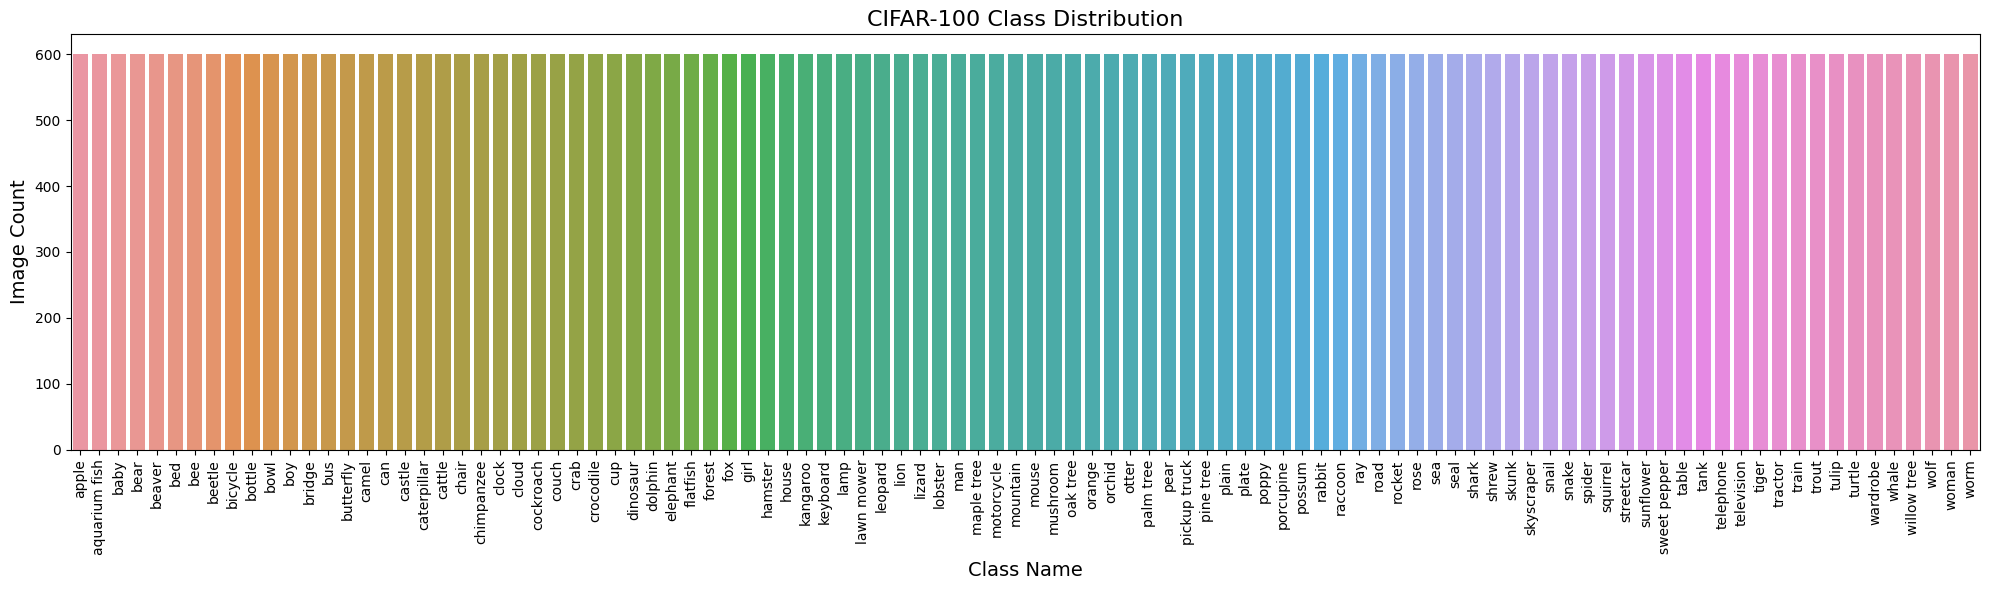

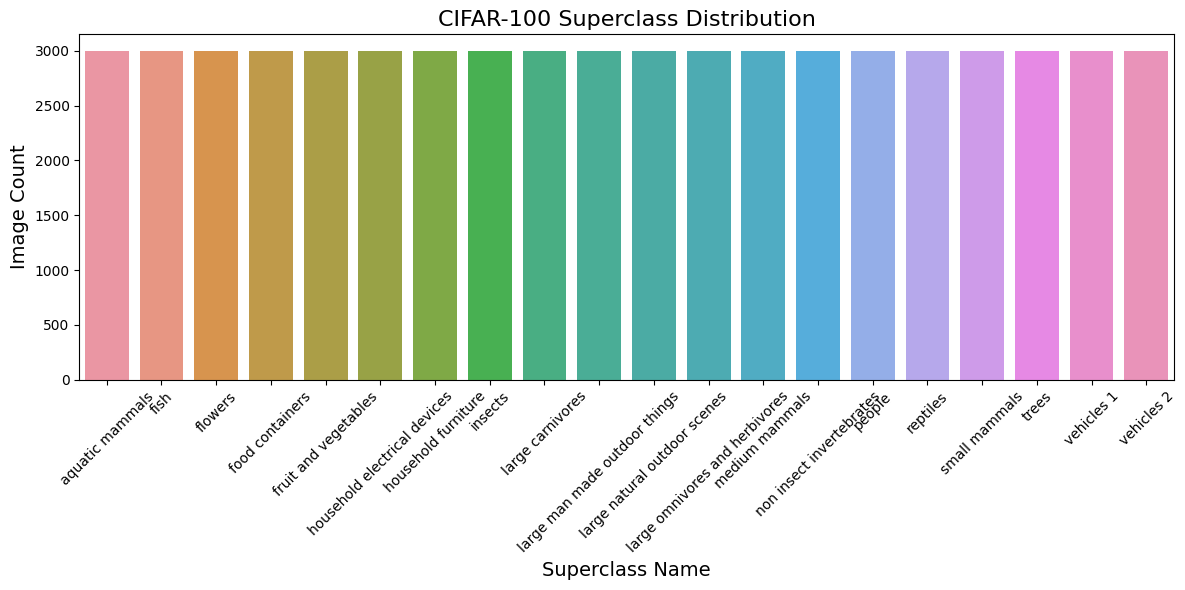

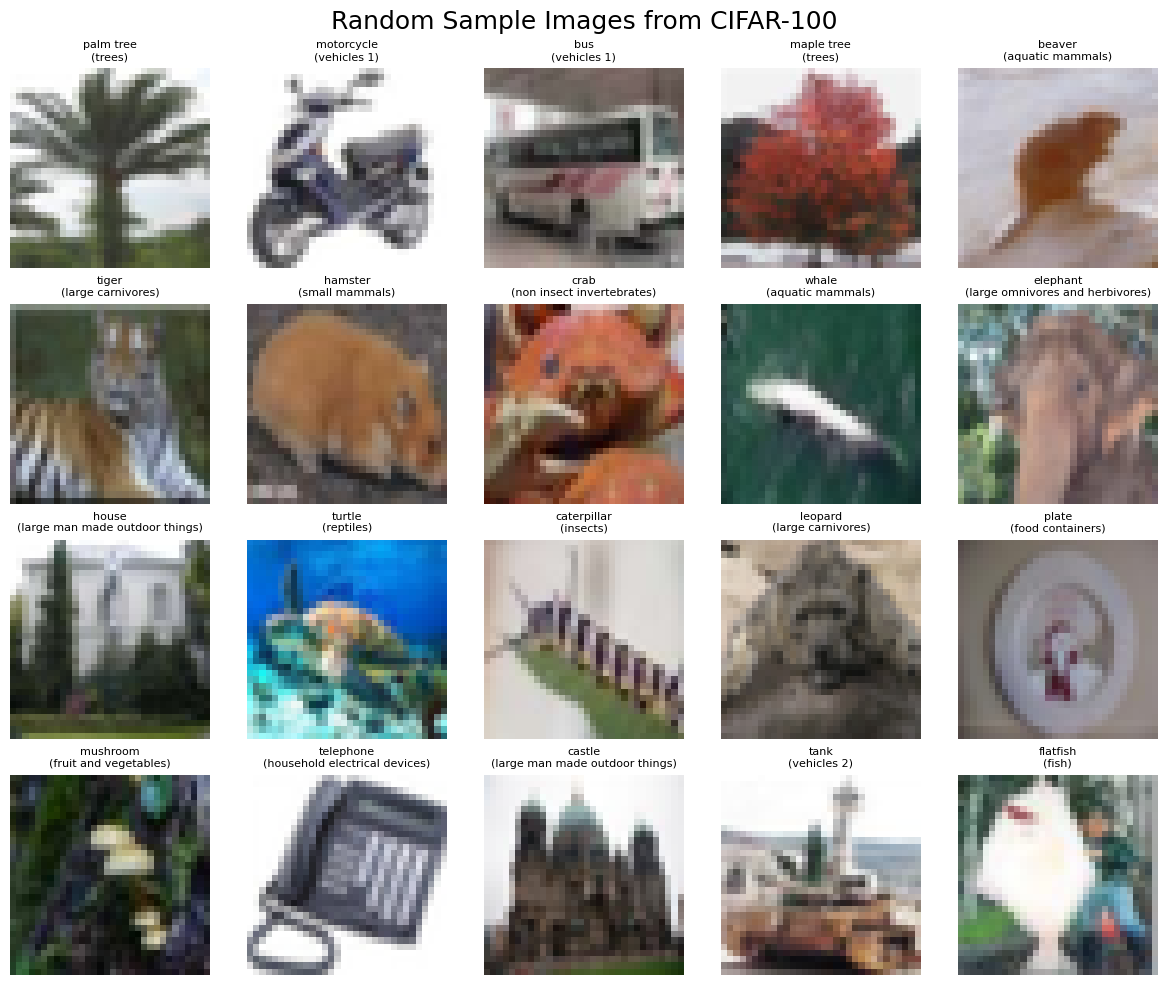

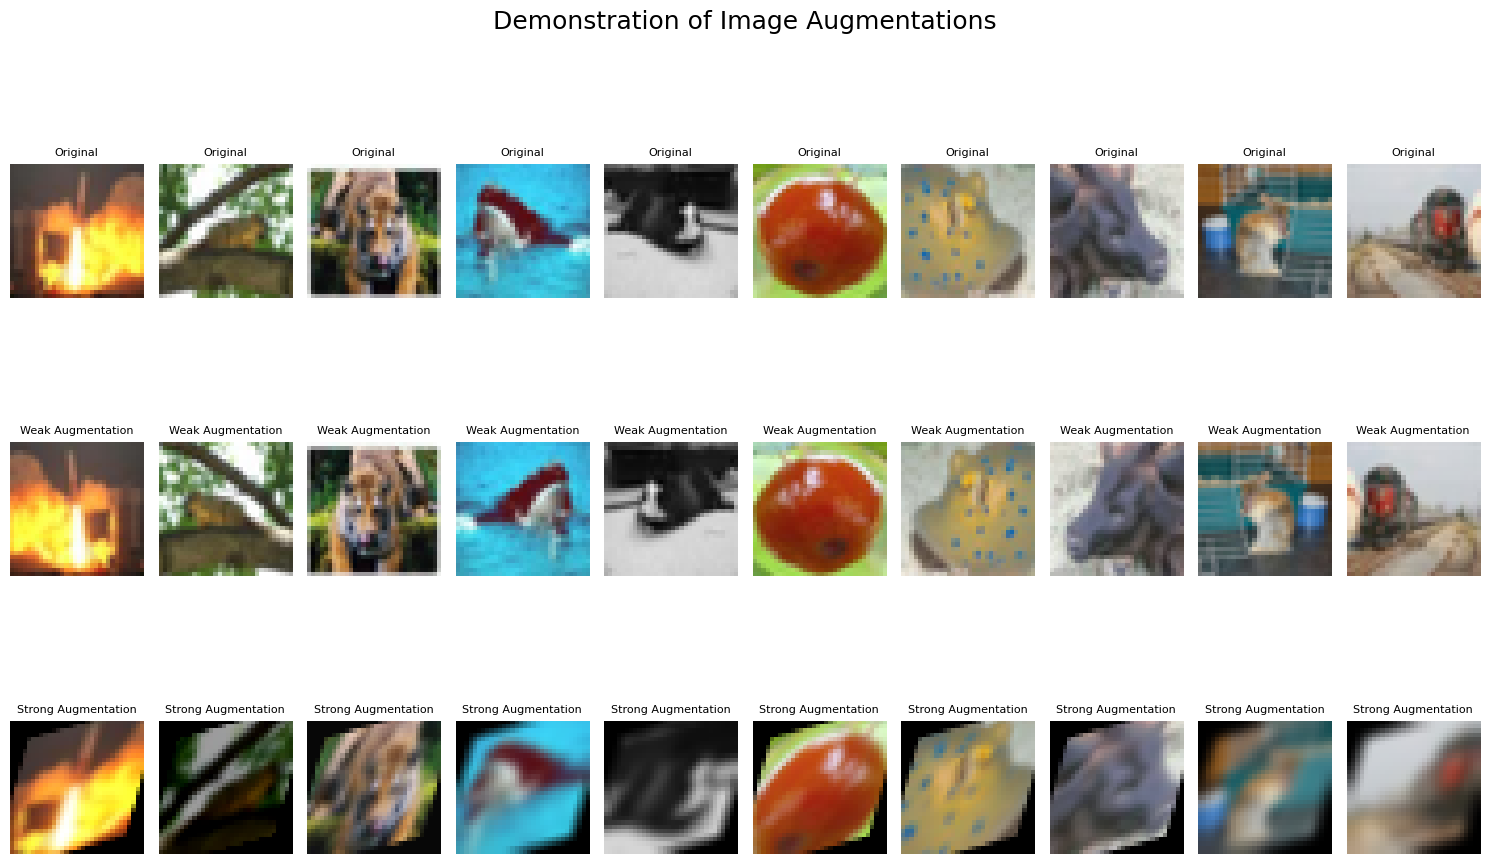


=== Running experiment with 75 labeled samples per class ===

[Data Split] Fixed Count: 75 labeled samples per class
Labeled Training Data: 7500 samples
Unlabeled Training Data: 40500 samples
Validation Data: 6000 samples
Test Data: 6000 samples


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 146MB/s] 


[Epoch Completed] FC=75  Ep[1/20]  TrainLoss: 5.2983 | TrainAcc: 2.72%  SupLoss: 4.6590 | UnsupLoss: 0.7991  ValLoss: 4.5621 | ValAcc: 4.87%


[Epoch Completed] FC=75  Ep[2/20]  TrainLoss: 4.8827 | TrainAcc: 10.72%  SupLoss: 4.0037 | UnsupLoss: 1.0988  ValLoss: 3.7914 | ValAcc: 14.68%


[Epoch Completed] FC=75  Ep[3/20]  TrainLoss: 4.5735 | TrainAcc: 22.00%  SupLoss: 3.2789 | UnsupLoss: 1.6183  ValLoss: 3.4004 | ValAcc: 20.90%


[Epoch Completed] FC=75  Ep[4/20]  TrainLoss: 4.3082 | TrainAcc: 32.91%  SupLoss: 2.6871 | UnsupLoss: 2.0263  ValLoss: 3.1589 | ValAcc: 25.15%


[Epoch Completed] FC=75  Ep[5/20]  TrainLoss: 4.0917 | TrainAcc: 40.37%  SupLoss: 2.2882 | UnsupLoss: 2.2544  ValLoss: 3.1876 | ValAcc: 26.48%


[Epoch Completed] FC=75  Ep[6/20]  TrainLoss: 3.8895 | TrainAcc: 47.88%  SupLoss: 1.9413 | UnsupLoss: 2.4353  ValLoss: 3.0679 | ValAcc: 28.70%


[Epoch Completed] FC=75  Ep[7/20]  TrainLoss: 3.6320 | TrainAcc: 50.12%  SupLoss: 1.7600 | UnsupLoss: 2.3401  ValLoss: 3.0700 | ValAcc: 29.40%


[Epoch Completed] FC=75  Ep[8/20]  TrainLoss: 3.3426 | TrainAcc: 52.23%  SupLoss: 1.5906 | UnsupLoss: 2.1899  ValLoss: 2.9479 | ValAcc: 31.15%


[Epoch Completed] FC=75  Ep[9/20]  TrainLoss: 3.3081 | TrainAcc: 67.56%  SupLoss: 1.1634 | UnsupLoss: 2.6809  ValLoss: 2.8212 | ValAcc: 34.67%


[Epoch Completed] FC=75  Ep[10/20]  TrainLoss: 3.3298 | TrainAcc: 73.00%  SupLoss: 1.0201 | UnsupLoss: 2.8871  ValLoss: 2.8446 | ValAcc: 35.77%


[Epoch Completed] FC=75  Ep[11/20]  TrainLoss: 3.1817 | TrainAcc: 74.73%  SupLoss: 0.9308 | UnsupLoss: 2.8136  ValLoss: 2.8404 | ValAcc: 35.70%


[Epoch Completed] FC=75  Ep[12/20]  TrainLoss: 2.9515 | TrainAcc: 74.97%  SupLoss: 0.8471 | UnsupLoss: 2.6306  ValLoss: 2.9707 | ValAcc: 33.93%


[Epoch Completed] FC=75  Ep[13/20]  TrainLoss: 2.8459 | TrainAcc: 70.23%  SupLoss: 0.9060 | UnsupLoss: 2.4249  ValLoss: 3.2319 | ValAcc: 30.93%


[Epoch Completed] FC=75  Ep[14/20]  TrainLoss: 2.4549 | TrainAcc: 69.17%  SupLoss: 0.8583 | UnsupLoss: 1.9958  ValLoss: 3.1543 | ValAcc: 31.78%


[Epoch Completed] FC=75  Ep[15/20]  TrainLoss: 2.2654 | TrainAcc: 74.75%  SupLoss: 0.7302 | UnsupLoss: 1.9190  ValLoss: 3.2131 | ValAcc: 30.73%


[Epoch Completed] FC=75  Ep[16/20]  TrainLoss: 2.1896 | TrainAcc: 80.81%  SupLoss: 0.6177 | UnsupLoss: 1.9650  ValLoss: 3.0721 | ValAcc: 32.43%


[Epoch Completed] FC=75  Ep[17/20]  TrainLoss: 2.1635 | TrainAcc: 85.55%  SupLoss: 0.5296 | UnsupLoss: 2.0423  ValLoss: 3.1240 | ValAcc: 31.30%


[Epoch Completed] FC=75  Ep[18/20]  TrainLoss: 2.1434 | TrainAcc: 88.95%  SupLoss: 0.4828 | UnsupLoss: 2.0757  ValLoss: 3.0426 | ValAcc: 33.32%


[Epoch Completed] FC=75  Ep[19/20]  TrainLoss: 2.2064 | TrainAcc: 90.85%  SupLoss: 0.4409 | UnsupLoss: 2.2069  ValLoss: 3.0380 | ValAcc: 33.13%


[Epoch Completed] FC=75  Ep[20/20]  TrainLoss: 2.1760 | TrainAcc: 90.17%  SupLoss: 0.4492 | UnsupLoss: 2.1585  ValLoss: 3.0318 | ValAcc: 33.17%

[Test Evaluation] FC=75  Test Accuracy: 31.93% | ROC AUC: 0.9355 | AvgPrecision: 0.3829
               precision    recall  f1-score   support

   maple tree       0.49      0.28      0.36        60
    pine tree       0.32      0.27      0.29        60
     oak tree       0.49      0.72      0.58        60
  willow tree       0.55      0.35      0.43        60
    palm tree       0.49      0.58      0.53        60
        clock       0.46      0.35      0.40        60
   television       0.65      0.40      0.49        60
    telephone       0.53      0.42      0.47        60
         lamp       0.74      0.23      0.35        60
     keyboard       0.66      0.70      0.68        60
        otter       0.16      0.05      0.08        60
        whale       0.40      0.48      0.44        60
       beaver       0.15      0.03      0.05       

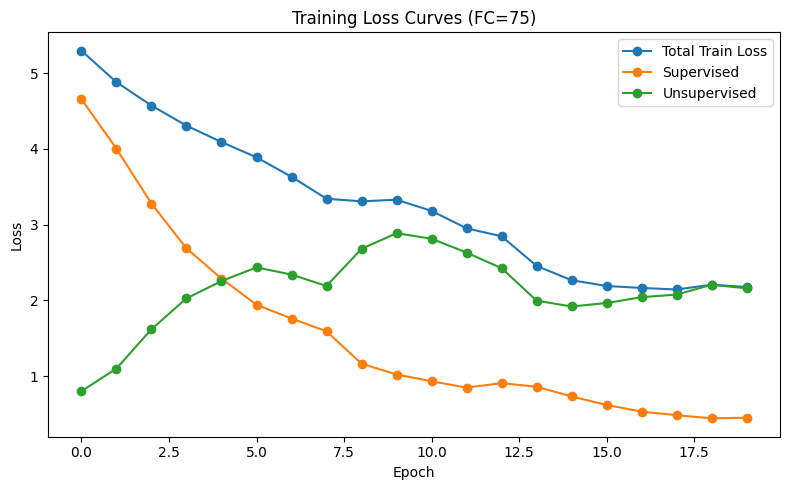

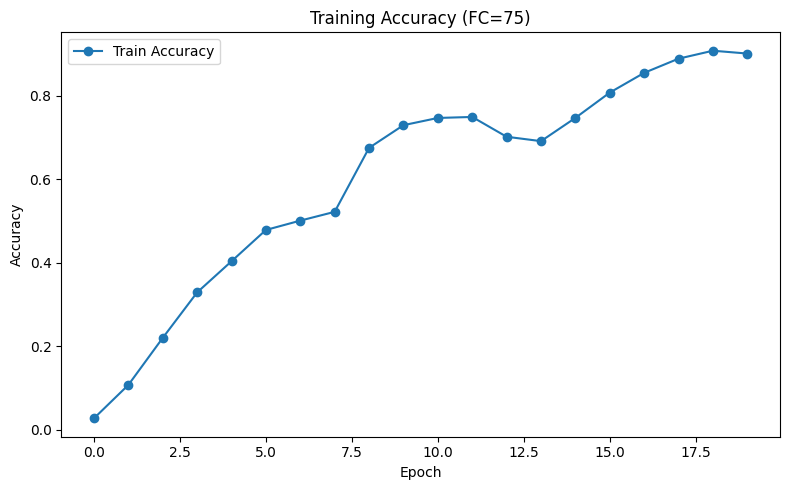

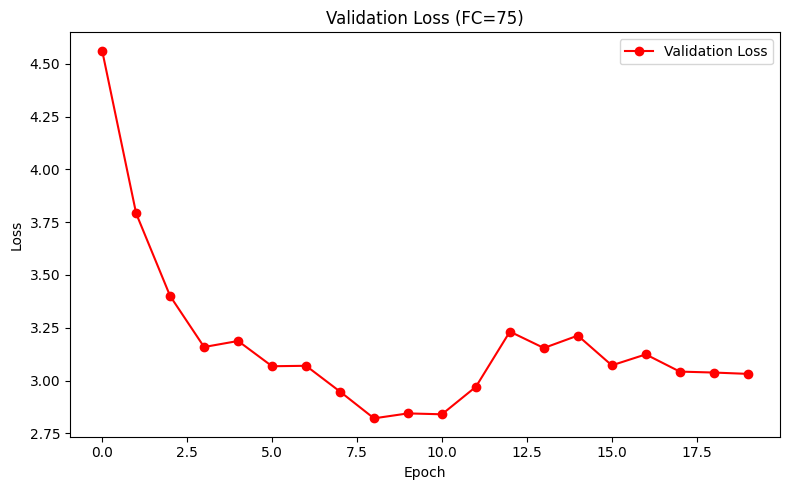

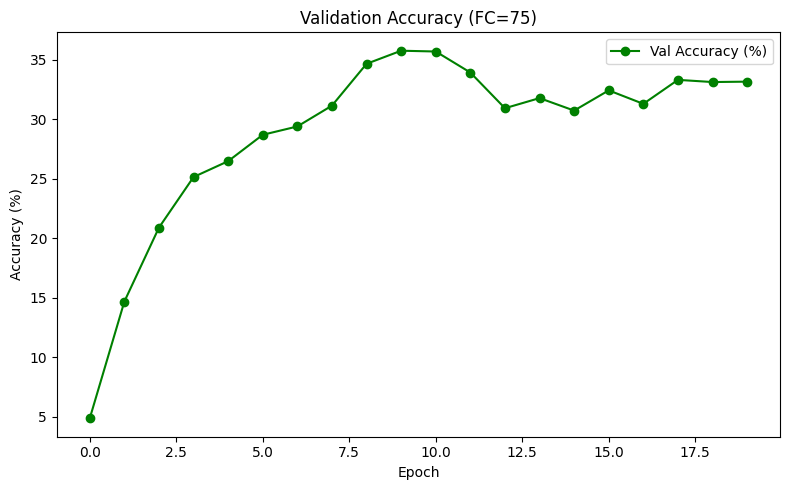

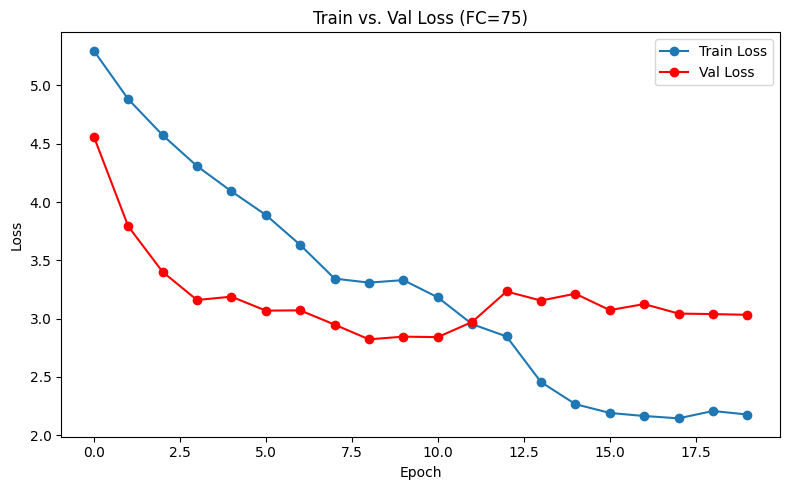

--- Finished plotting for 75 labeled/class ---

=== Running experiment with 175 labeled samples per class ===

[Data Split] Fixed Count: 175 labeled samples per class
Labeled Training Data: 17500 samples
Unlabeled Training Data: 30500 samples
Validation Data: 6000 samples
Test Data: 6000 samples


[Epoch Completed] FC=175  Ep[1/20]  TrainLoss: 5.5683 | TrainAcc: 2.81%  SupLoss: 4.7682 | UnsupLoss: 1.0001  ValLoss: 4.2543 | ValAcc: 10.30%


[Epoch Completed] FC=175  Ep[2/20]  TrainLoss: 4.8313 | TrainAcc: 19.74%  SupLoss: 3.4014 | UnsupLoss: 1.7874  ValLoss: 3.1497 | ValAcc: 24.87%


[Epoch Completed] FC=175  Ep[3/20]  TrainLoss: 4.3564 | TrainAcc: 32.69%  SupLoss: 2.6228 | UnsupLoss: 2.1670  ValLoss: 2.6340 | ValAcc: 35.03%


[Epoch Completed] FC=175  Ep[4/20]  TrainLoss: 3.9422 | TrainAcc: 44.85%  SupLoss: 2.0422 | UnsupLoss: 2.3750  ValLoss: 2.3940 | ValAcc: 39.95%


[Epoch Completed] FC=175  Ep[5/20]  TrainLoss: 3.6431 | TrainAcc: 53.07%  SupLoss: 1.6807 | UnsupLoss: 2.4530  ValLoss: 2.2511 | ValAcc: 44.47%


[Epoch Completed] FC=175  Ep[6/20]  TrainLoss: 3.4539 | TrainAcc: 58.92%  SupLoss: 1.4204 | UnsupLoss: 2.5418  ValLoss: 2.1753 | ValAcc: 45.62%


[Epoch Completed] FC=175  Ep[7/20]  TrainLoss: 3.2623 | TrainAcc: 64.31%  SupLoss: 1.2158 | UnsupLoss: 2.5581  ValLoss: 2.1796 | ValAcc: 46.57%


[Epoch Completed] FC=175  Ep[8/20]  TrainLoss: 3.0923 | TrainAcc: 69.38%  SupLoss: 1.0373 | UnsupLoss: 2.5688  ValLoss: 2.0935 | ValAcc: 48.28%


[Epoch Completed] FC=175  Ep[9/20]  TrainLoss: 2.9272 | TrainAcc: 73.10%  SupLoss: 0.8951 | UnsupLoss: 2.5401  ValLoss: 2.0322 | ValAcc: 50.83%


[Epoch Completed] FC=175  Ep[10/20]  TrainLoss: 2.7685 | TrainAcc: 77.25%  SupLoss: 0.7533 | UnsupLoss: 2.5190  ValLoss: 1.9825 | ValAcc: 52.38%


[Epoch Completed] FC=175  Ep[11/20]  TrainLoss: 2.6504 | TrainAcc: 80.71%  SupLoss: 0.6417 | UnsupLoss: 2.5108  ValLoss: 1.9619 | ValAcc: 52.52%


[Epoch Completed] FC=175  Ep[12/20]  TrainLoss: 2.5532 | TrainAcc: 83.93%  SupLoss: 0.5435 | UnsupLoss: 2.5121  ValLoss: 2.0057 | ValAcc: 52.45%


[Epoch Completed] FC=175  Ep[13/20]  TrainLoss: 2.4158 | TrainAcc: 86.81%  SupLoss: 0.4663 | UnsupLoss: 2.4369  ValLoss: 1.9362 | ValAcc: 53.95%


[Epoch Completed] FC=175  Ep[14/20]  TrainLoss: 2.3031 | TrainAcc: 89.14%  SupLoss: 0.3972 | UnsupLoss: 2.3824  ValLoss: 1.9526 | ValAcc: 53.75%


[Epoch Completed] FC=175  Ep[15/20]  TrainLoss: 2.1951 | TrainAcc: 91.64%  SupLoss: 0.3400 | UnsupLoss: 2.3189  ValLoss: 1.9504 | ValAcc: 54.55%


[Epoch Completed] FC=175  Ep[16/20]  TrainLoss: 2.1628 | TrainAcc: 92.67%  SupLoss: 0.3051 | UnsupLoss: 2.3221  ValLoss: 1.9344 | ValAcc: 54.48%


[Epoch Completed] FC=175  Ep[17/20]  TrainLoss: 2.0775 | TrainAcc: 93.97%  SupLoss: 0.2750 | UnsupLoss: 2.2532  ValLoss: 1.9241 | ValAcc: 55.17%


[Epoch Completed] FC=175  Ep[18/20]  TrainLoss: 2.0485 | TrainAcc: 94.59%  SupLoss: 0.2571 | UnsupLoss: 2.2393  ValLoss: 1.9274 | ValAcc: 54.60%


[Epoch Completed] FC=175  Ep[19/20]  TrainLoss: 2.0022 | TrainAcc: 95.13%  SupLoss: 0.2453 | UnsupLoss: 2.1961  ValLoss: 1.9120 | ValAcc: 55.05%


[Epoch Completed] FC=175  Ep[20/20]  TrainLoss: 2.0133 | TrainAcc: 95.37%  SupLoss: 0.2372 | UnsupLoss: 2.2202  ValLoss: 1.9144 | ValAcc: 54.85%

[Test Evaluation] FC=175  Test Accuracy: 54.15% | ROC AUC: 0.9727 | AvgPrecision: 0.5747
               precision    recall  f1-score   support

   maple tree       0.69      0.37      0.48        60
    pine tree       0.49      0.57      0.52        60
     oak tree       0.58      0.83      0.68        60
  willow tree       0.59      0.38      0.46        60
    palm tree       0.84      0.78      0.81        60
        clock       0.58      0.63      0.61        60
   television       0.64      0.58      0.61        60
    telephone       0.56      0.72      0.63        60
         lamp       0.59      0.53      0.56        60
     keyboard       0.70      0.73      0.72        60
        otter       0.28      0.17      0.21        60
        whale       0.51      0.58      0.55        60
       beaver       0.28      0.28      0.28     

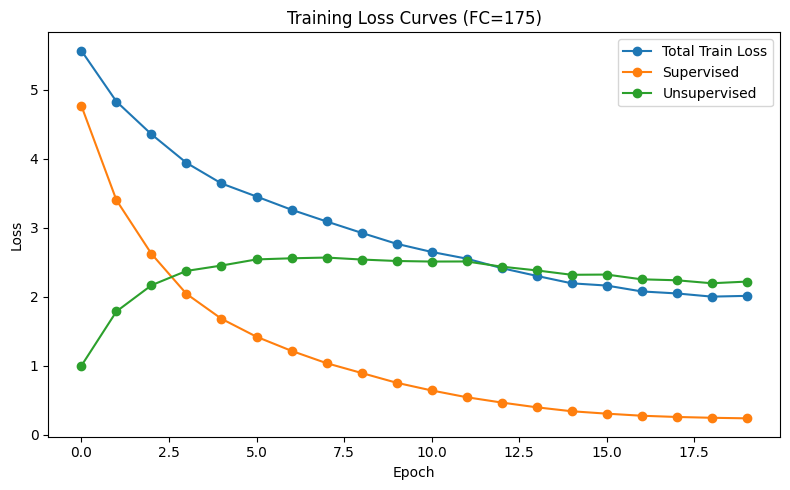

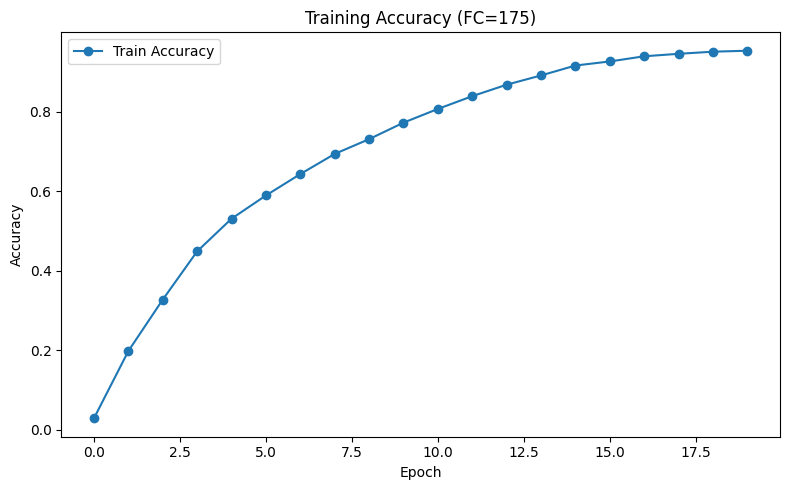

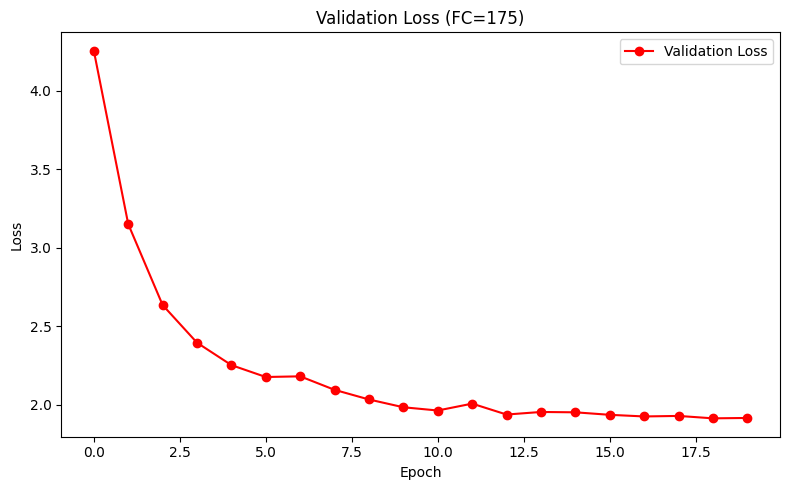

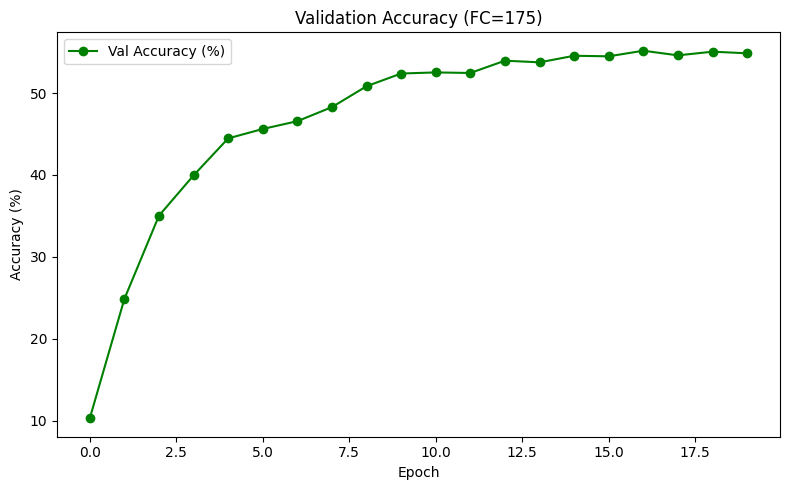

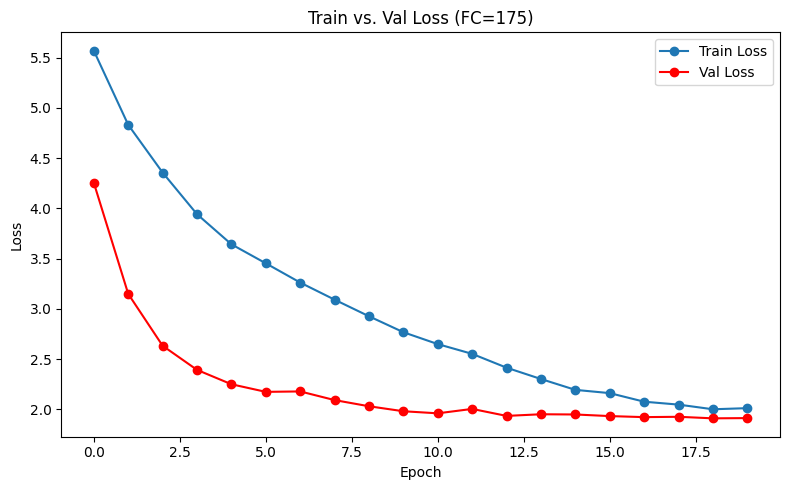

--- Finished plotting for 175 labeled/class ---

=== Running experiment with 260 labeled samples per class ===

[Data Split] Fixed Count: 260 labeled samples per class
Labeled Training Data: 26000 samples
Unlabeled Training Data: 22000 samples
Validation Data: 6000 samples
Test Data: 6000 samples


[Epoch Completed] FC=260  Ep[1/20]  TrainLoss: 5.3737 | TrainAcc: 7.32%  SupLoss: 4.4632 | UnsupLoss: 1.1381  ValLoss: 3.6122 | ValAcc: 18.02%


[Epoch Completed] FC=260  Ep[2/20]  TrainLoss: 4.5292 | TrainAcc: 28.46%  SupLoss: 2.8820 | UnsupLoss: 2.0589  ValLoss: 2.5144 | ValAcc: 35.77%


[Epoch Completed] FC=260  Ep[3/20]  TrainLoss: 4.0134 | TrainAcc: 43.43%  SupLoss: 2.1003 | UnsupLoss: 2.3914  ValLoss: 2.2178 | ValAcc: 43.47%


[Epoch Completed] FC=260  Ep[4/20]  TrainLoss: 3.6603 | TrainAcc: 52.80%  SupLoss: 1.7058 | UnsupLoss: 2.4432  ValLoss: 2.0791 | ValAcc: 47.12%


[Epoch Completed] FC=260  Ep[5/20]  TrainLoss: 3.4018 | TrainAcc: 58.63%  SupLoss: 1.4408 | UnsupLoss: 2.4512  ValLoss: 1.9345 | ValAcc: 51.00%


[Epoch Completed] FC=260  Ep[6/20]  TrainLoss: 3.1795 | TrainAcc: 63.42%  SupLoss: 1.2450 | UnsupLoss: 2.4182  ValLoss: 1.8184 | ValAcc: 52.32%


[Epoch Completed] FC=260  Ep[7/20]  TrainLoss: 3.0025 | TrainAcc: 68.00%  SupLoss: 1.0799 | UnsupLoss: 2.4032  ValLoss: 1.7905 | ValAcc: 54.43%


[Epoch Completed] FC=260  Ep[8/20]  TrainLoss: 2.8059 | TrainAcc: 71.57%  SupLoss: 0.9302 | UnsupLoss: 2.3446  ValLoss: 1.7546 | ValAcc: 55.97%


[Epoch Completed] FC=260  Ep[9/20]  TrainLoss: 2.6584 | TrainAcc: 75.62%  SupLoss: 0.8072 | UnsupLoss: 2.3140  ValLoss: 1.7634 | ValAcc: 57.02%


[Epoch Completed] FC=260  Ep[10/20]  TrainLoss: 2.5126 | TrainAcc: 78.41%  SupLoss: 0.6971 | UnsupLoss: 2.2693  ValLoss: 1.6957 | ValAcc: 57.83%


[Epoch Completed] FC=260  Ep[11/20]  TrainLoss: 2.3612 | TrainAcc: 81.92%  SupLoss: 0.5803 | UnsupLoss: 2.2262  ValLoss: 1.7261 | ValAcc: 57.63%


[Epoch Completed] FC=260  Ep[12/20]  TrainLoss: 2.1760 | TrainAcc: 84.37%  SupLoss: 0.5037 | UnsupLoss: 2.0904  ValLoss: 1.7237 | ValAcc: 58.05%


[Epoch Completed] FC=260  Ep[13/20]  TrainLoss: 2.0484 | TrainAcc: 87.17%  SupLoss: 0.4168 | UnsupLoss: 2.0395  ValLoss: 1.7089 | ValAcc: 59.30%


[Epoch Completed] FC=260  Ep[14/20]  TrainLoss: 1.9614 | TrainAcc: 89.57%  SupLoss: 0.3607 | UnsupLoss: 2.0009  ValLoss: 1.7290 | ValAcc: 58.92%


[Epoch Completed] FC=260  Ep[15/20]  TrainLoss: 1.8313 | TrainAcc: 91.67%  SupLoss: 0.3064 | UnsupLoss: 1.9061  ValLoss: 1.6956 | ValAcc: 59.42%


[Epoch Completed] FC=260  Ep[16/20]  TrainLoss: 1.7687 | TrainAcc: 93.03%  SupLoss: 0.2693 | UnsupLoss: 1.8742  ValLoss: 1.6925 | ValAcc: 59.15%


[Epoch Completed] FC=260  Ep[17/20]  TrainLoss: 1.6874 | TrainAcc: 94.37%  SupLoss: 0.2398 | UnsupLoss: 1.8095  ValLoss: 1.6884 | ValAcc: 60.18%


[Epoch Completed] FC=260  Ep[18/20]  TrainLoss: 1.6394 | TrainAcc: 94.92%  SupLoss: 0.2231 | UnsupLoss: 1.7705  ValLoss: 1.6829 | ValAcc: 60.35%


[Epoch Completed] FC=260  Ep[19/20]  TrainLoss: 1.6063 | TrainAcc: 95.56%  SupLoss: 0.2072 | UnsupLoss: 1.7489  ValLoss: 1.6856 | ValAcc: 60.42%


[Epoch Completed] FC=260  Ep[20/20]  TrainLoss: 1.5876 | TrainAcc: 95.93%  SupLoss: 0.2013 | UnsupLoss: 1.7330  ValLoss: 1.6766 | ValAcc: 60.57%

[Test Evaluation] FC=260  Test Accuracy: 59.42% | ROC AUC: 0.9807 | AvgPrecision: 0.6447
               precision    recall  f1-score   support

   maple tree       0.69      0.33      0.45        60
    pine tree       0.61      0.58      0.60        60
     oak tree       0.59      0.82      0.69        60
  willow tree       0.57      0.48      0.52        60
    palm tree       0.82      0.83      0.83        60
        clock       0.64      0.82      0.72        60
   television       0.74      0.53      0.62        60
    telephone       0.66      0.77      0.71        60
         lamp       0.59      0.68      0.64        60
     keyboard       0.81      0.85      0.83        60
        otter       0.08      0.10      0.09        60
        whale       0.53      0.73      0.62        60
       beaver       0.37      0.33      0.35     

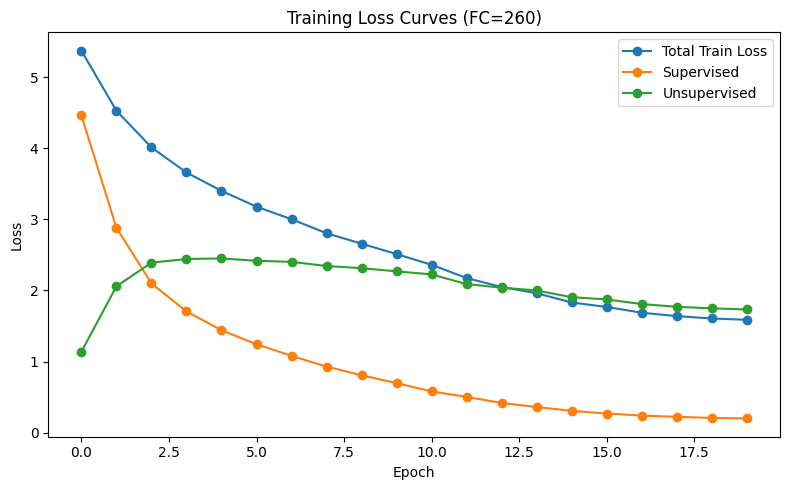

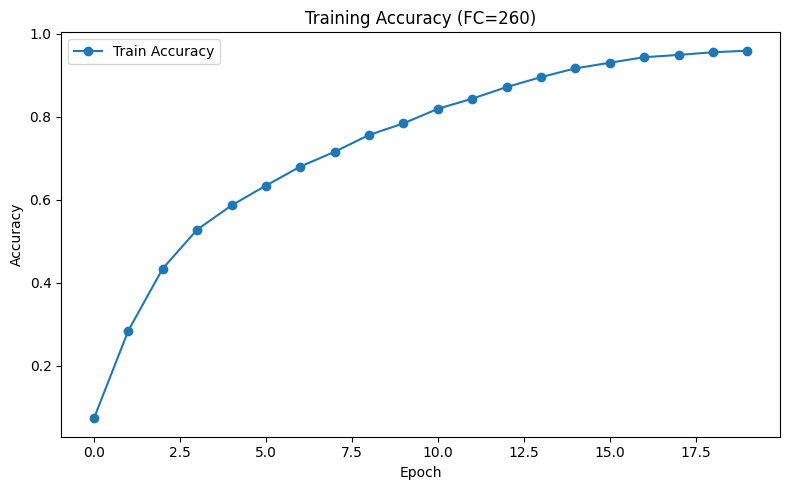

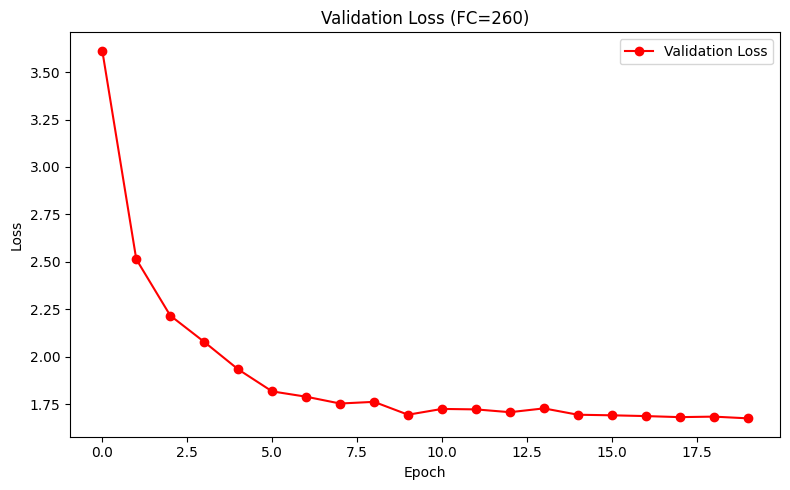

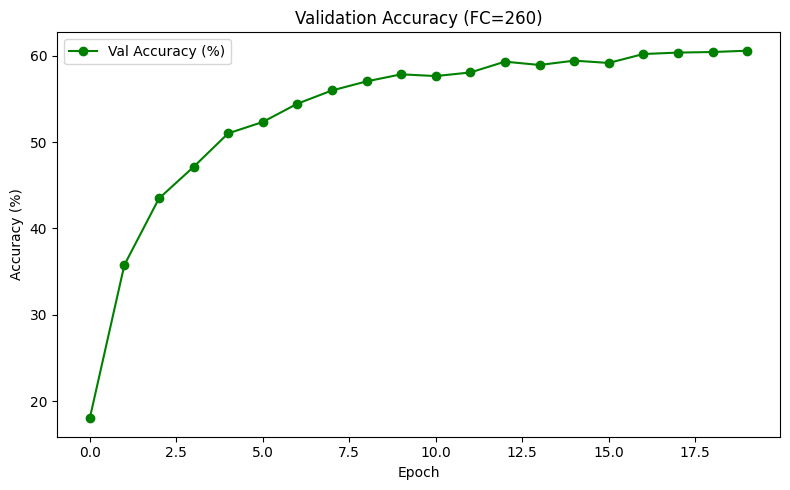

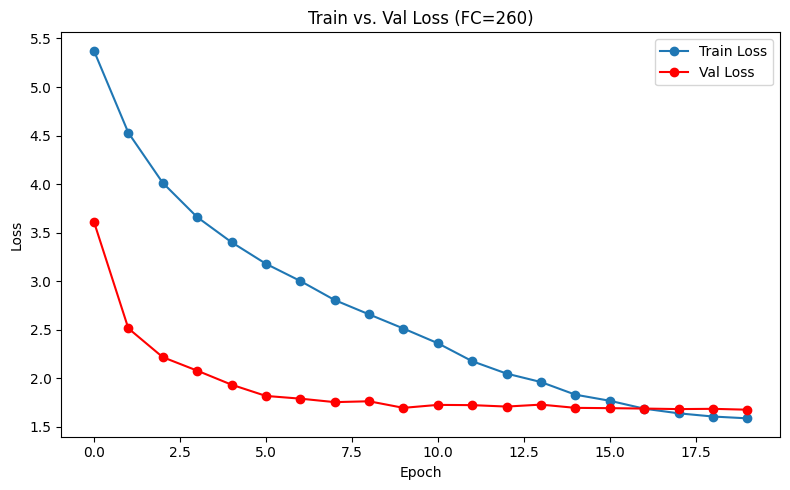

--- Finished plotting for 260 labeled/class ---

=== Running experiment with 360 labeled samples per class ===

[Data Split] Fixed Count: 360 labeled samples per class
Labeled Training Data: 36000 samples
Unlabeled Training Data: 12000 samples
Validation Data: 6000 samples
Test Data: 6000 samples


[Epoch Completed] FC=360  Ep[1/20]  TrainLoss: 5.1857 | TrainAcc: 11.52%  SupLoss: 4.1155 | UnsupLoss: 1.3377  ValLoss: 3.0808 | ValAcc: 26.18%


[Epoch Completed] FC=360  Ep[2/20]  TrainLoss: 4.1539 | TrainAcc: 36.32%  SupLoss: 2.4472 | UnsupLoss: 2.1333  ValLoss: 2.2758 | ValAcc: 41.77%


[Epoch Completed] FC=360  Ep[3/20]  TrainLoss: 3.5383 | TrainAcc: 49.75%  SupLoss: 1.8266 | UnsupLoss: 2.1396  ValLoss: 1.9625 | ValAcc: 48.43%


[Epoch Completed] FC=360  Ep[4/20]  TrainLoss: 3.1540 | TrainAcc: 57.77%  SupLoss: 1.4864 | UnsupLoss: 2.0844  ValLoss: 1.8039 | ValAcc: 53.40%


[Epoch Completed] FC=360  Ep[5/20]  TrainLoss: 2.8223 | TrainAcc: 63.69%  SupLoss: 1.2455 | UnsupLoss: 1.9710  ValLoss: 1.6384 | ValAcc: 56.47%


[Epoch Completed] FC=360  Ep[6/20]  TrainLoss: 2.5322 | TrainAcc: 68.51%  SupLoss: 1.0589 | UnsupLoss: 1.8417  ValLoss: 1.5890 | ValAcc: 58.40%


[Epoch Completed] FC=360  Ep[7/20]  TrainLoss: 2.3354 | TrainAcc: 72.32%  SupLoss: 0.9136 | UnsupLoss: 1.7773  ValLoss: 1.6030 | ValAcc: 59.10%


[Epoch Completed] FC=360  Ep[8/20]  TrainLoss: 2.1272 | TrainAcc: 76.17%  SupLoss: 0.7832 | UnsupLoss: 1.6800  ValLoss: 1.5062 | ValAcc: 61.78%


[Epoch Completed] FC=360  Ep[9/20]  TrainLoss: 1.9428 | TrainAcc: 79.41%  SupLoss: 0.6705 | UnsupLoss: 1.5904  ValLoss: 1.5423 | ValAcc: 62.00%


[Epoch Completed] FC=360  Ep[10/20]  TrainLoss: 1.7810 | TrainAcc: 82.50%  SupLoss: 0.5632 | UnsupLoss: 1.5223  ValLoss: 1.5217 | ValAcc: 61.88%


[Epoch Completed] FC=360  Ep[11/20]  TrainLoss: 1.5930 | TrainAcc: 85.46%  SupLoss: 0.4690 | UnsupLoss: 1.4050  ValLoss: 1.4927 | ValAcc: 63.15%


[Epoch Completed] FC=360  Ep[12/20]  TrainLoss: 1.4199 | TrainAcc: 88.22%  SupLoss: 0.3920 | UnsupLoss: 1.2849  ValLoss: 1.5183 | ValAcc: 62.87%


[Epoch Completed] FC=360  Ep[13/20]  TrainLoss: 1.2971 | TrainAcc: 90.64%  SupLoss: 0.3207 | UnsupLoss: 1.2205  ValLoss: 1.5405 | ValAcc: 63.22%


[Epoch Completed] FC=360  Ep[14/20]  TrainLoss: 1.1708 | TrainAcc: 92.56%  SupLoss: 0.2690 | UnsupLoss: 1.1272  ValLoss: 1.5491 | ValAcc: 62.83%


[Epoch Completed] FC=360  Ep[15/20]  TrainLoss: 1.0464 | TrainAcc: 94.42%  SupLoss: 0.2197 | UnsupLoss: 1.0333  ValLoss: 1.5335 | ValAcc: 63.00%


[Epoch Completed] FC=360  Ep[16/20]  TrainLoss: 0.9797 | TrainAcc: 95.53%  SupLoss: 0.1893 | UnsupLoss: 0.9881  ValLoss: 1.5358 | ValAcc: 63.58%


[Epoch Completed] FC=360  Ep[17/20]  TrainLoss: 0.8933 | TrainAcc: 96.46%  SupLoss: 0.1622 | UnsupLoss: 0.9139  ValLoss: 1.5249 | ValAcc: 63.60%


[Epoch Completed] FC=360  Ep[18/20]  TrainLoss: 0.8605 | TrainAcc: 97.23%  SupLoss: 0.1450 | UnsupLoss: 0.8944  ValLoss: 1.5234 | ValAcc: 63.67%


[Epoch Completed] FC=360  Ep[19/20]  TrainLoss: 0.8182 | TrainAcc: 97.64%  SupLoss: 0.1349 | UnsupLoss: 0.8541  ValLoss: 1.5242 | ValAcc: 63.93%


[Epoch Completed] FC=360  Ep[20/20]  TrainLoss: 0.7873 | TrainAcc: 97.66%  SupLoss: 0.1298 | UnsupLoss: 0.8218  ValLoss: 1.5235 | ValAcc: 63.48%

[Test Evaluation] FC=360  Test Accuracy: 63.23% | ROC AUC: 0.9832 | AvgPrecision: 0.6864
               precision    recall  f1-score   support

   maple tree       0.67      0.48      0.56        60
    pine tree       0.64      0.58      0.61        60
     oak tree       0.62      0.88      0.73        60
  willow tree       0.63      0.45      0.52        60
    palm tree       0.81      0.83      0.82        60
        clock       0.71      0.77      0.74        60
   television       0.74      0.70      0.72        60
    telephone       0.69      0.82      0.75        60
         lamp       0.65      0.62      0.63        60
     keyboard       0.79      0.77      0.78        60
        otter       0.27      0.20      0.23        60
        whale       0.58      0.73      0.65        60
       beaver       0.44      0.55      0.49     

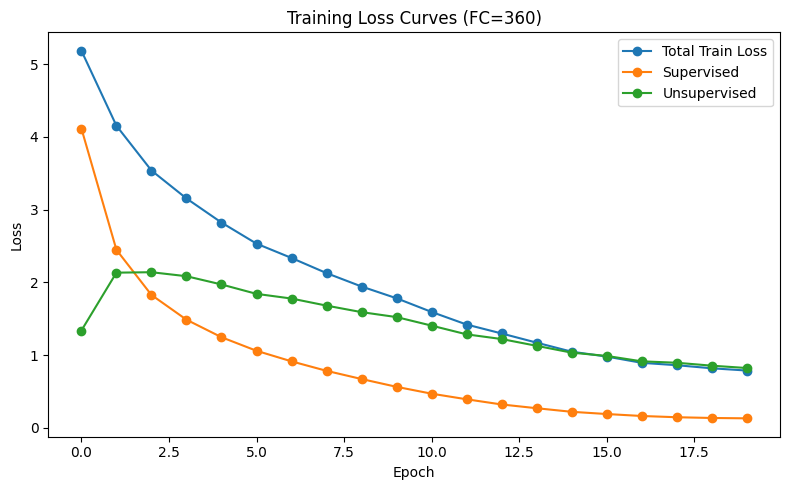

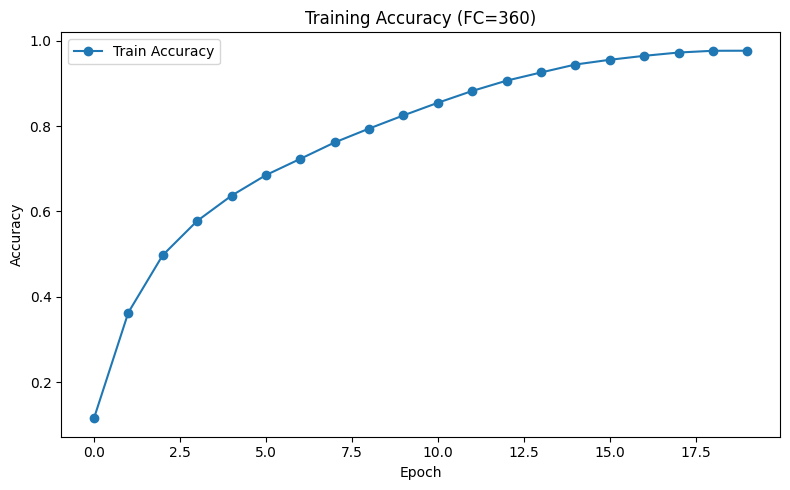

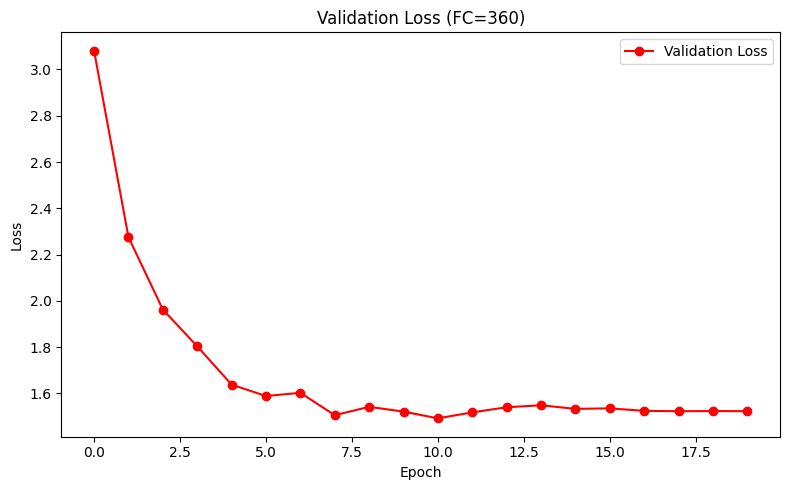

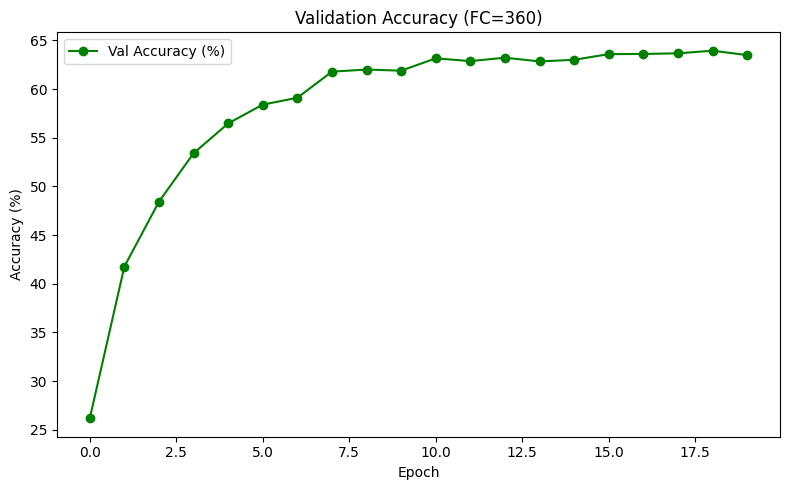

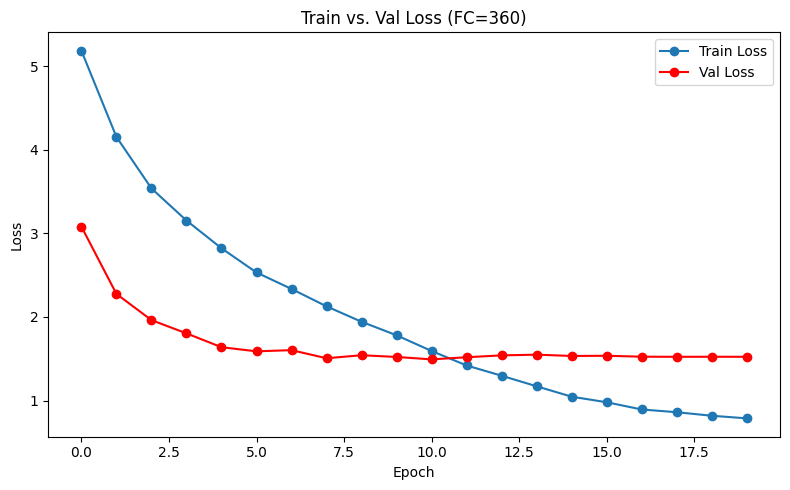

--- Finished plotting for 360 labeled/class ---

[Test Summary] Best run: 360 labeled samples per class with Test Accuracy: 63.23%


In [ ]:
if __name__ == '__main__':
    from multiprocessing import freeze_support
    freeze_support()
    main()